In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#non complex model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pickle
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, peak_widths

import cvnn.layers as complex_layers

import joblib 

from numpy import linalg as LA

def nmrs (pred_np,y_tst):
    x=LA.norm(y_tst-pred_np)/LA.norm(y_tst-np.mean(y_tst))
    return x


In [2]:
#Loading data from csv

data = pd.read_csv('C:/Users/alamg/Desktop/Thesis_ML/graphene/data_absorbance.csv')
data_np= np.array(data)
data_500 = pd.read_csv('C:/Users/alamg/Desktop/Thesis_ML/graphene/data_500.csv')
data_raw=np.array(data_500)

In [3]:
#Extracting absorbance, s11 and x parameter from the csv by reading each data row by row and appending to the lists
data_abs=[]
data_s11=[]
data_param=[]
flag=0
#reshaping the data for better usebility
for j in range(0,len(data_raw),50):
    row=[]
    row2=[]
    value3= data_raw[flag,0:3]
    data_param.append(value3)
    for i in range(0,50,1):
        absob = data_raw[flag,5]
        s11= data_raw[flag,4]
        row.append(absob)
        row2.append(s11)
        flag=flag+1
    data_abs.append(row)
    data_s11.append(row2)

In [4]:
#defining datatypes
data_s11=np.array(data_s11,dtype='complex64')
data_abs=np.array(data_abs,dtype='float64')
data_param=np.array(data_param,dtype='float32')

In [ ]:
#plotting data to see if it has been loaded correctly 
sno=10



freq=np.arange(0,5000,1) #plaotting original data for verification
with plt.style.context('classic'): #sanity check if correct waveforms are loaded
    plt.plot(freq,y_data_extnd[pos[sno],:].T,label='complex', color='black')
    plt.scatter(data_3db[sno,0],y_data_extnd[pos[sno],data_3db[sno,0]],marker='o',color='green')
    plt.scatter(data_3db[sno,1],y_data_extnd[pos[sno],data_3db[sno,1]],marker='o',color='green')
    plt.scatter(data_3db[sno,2],0.5,marker='o',color='red')
    plt.scatter(data_3db[sno,3],0.5,marker='o',color='red')
#   plt.scatter(data_pR[sno],data_3db[sno],marker='x',color='blue')
#    plt.scatter(pos_LRp[sno],np.arange(0,1861,1),marker='x',color='red')
    plt.scatter(data_pk[sno],data_am[sno],marker='x',color='red')
    plt.scatter(data_pk[sno],data_am[sno]/2,marker='x',color='red')

    plt.xlabel("Freq (THz)")
    plt.ylabel("Absorbance")
    plt.show()
   # plt.legend(

In [7]:
# #data interpolation
w1=np.arange(0,5,0.1)
w2=np.arange(0,5,0.001)
ynew=[]
for i in range(0,len(data_abs)):
    row = np.interp(w2, w1, data_abs[i,:])
    ynew.append(row)

y_data_extnd=np.array(ynew)

In [16]:
#getting peaks, amplitude and half width of each wave

data_pk=[] # to store peaks
data_am=[] # to store amplitude
data_pL=[] # to store left position of peak  at 3db bandwidth 
data_pR=[] # to store Right position of peak  at 3db bandwidth 
#data_3db=[] #to save height of peak at 3db
pos=[] #storing position of each peak for later filtering peaks data from unfiltered list
d_m=[] #discarded peaks index
d_m2=[] #2 peaks store on this index, these are not discarded, we will only take the peak with higest amplitude and consider it as one peak

#getting peaks and saving discarded points
for i in range(len(data_abs)):
    peaks, _ = find_peaks(y_data_extnd[i,:],height=0.5) 
    if len(peaks)==1:
        data_pk.append(peaks)
        data_am.append(y_data_extnd[i,(peaks)])
     #   j = peak_widths(y_data_extnd[i,:], peaks, rel_height=0.5)
     #   data_pL.append(j[2][0])
     #   data_pR.append(j[3][0])
     #   data_3db.append(j[1][0])
        pos.append(i)
    elif len(peaks)==2:
        data_pk.append(peaks)
        data_am.append(y_data_extnd[i,(peaks)])
     #   j = peak_widths(y_data_extnd[i,:], peaks, rel_height=0.5)
     #   data_pL.append(j[2][0])
     #   data_pR.append(j[3][0])
     #   data_3db.append(j[1][0])
        pos.append(i)
        d_m2.append(i)
    else:
        d_m.append(i)

In [17]:
#routine to store physical params of filtered data, so we take the index of the peaks that have been filtered and save their x data

i=0
j=0
k=0
x_data = pd.DataFrame()
#getting data for each peak response by taking X as different pos values for each 1,2,3 peak response
for i in range(0,len(pos)):
    j = pos[i]
    k = pd.DataFrame({"B":data_param[j,0],"W":data_param[j,1],"Ef":data_param[j,2]},index=[i])
    x_data = pd.concat([x_data, pd.DataFrame(k)], ignore_index=True)

In [18]:
#routine to store feature data of the filtered peaks, we take data_pk calculated previously, 
#data_am for amplitude and data_pk/data_qf to get qualitfy factor, so we take peak position and divide by its width

i=0
m=0
j=0
y_data = pd.DataFrame()
y_data_abs = []
#getting data for each peak response by taking y as different pos values for each 1,2,3 peak response
for i in range(0,len(pos)):
    j=pos[i]
    m = pd.DataFrame({"Peak":data_pk[i][0],"Amp":data_am[i][0]},index=[i])
    y_data = pd.concat([y_data, pd.DataFrame(m)], ignore_index=True)
    y_data_abs.append(data_abs[j,:])

In [19]:
#converting pandas DF to numpy array for easier manupulation in NN
y_data=np.array(y_data) #y_data is features data
x_data=np.array(x_data) #x_data is for parameter
y_data_abs = np.array(y_data_abs) #y_data_abs is for absorbance 

In [22]:
## Extracting absolute and relative 3db peak positions
L_3db=0 #Left peak position at relative 3db
R_3db=0 #Right peak position at relative 3db
indexL=0  
indexR=0
i=0
j=0
k=0
data_3db = pd.DataFrame() #PD dataframe to store results
#finding index of left and right peak position
for i in range(0,len(pos),1):
    best_diff=0.0005
    best_3db=0.001
    best2_diff=0.0005
    best2_3db=0.001

    A3db = round(data_am[i][0]/2,4)
    for j in range(0,2500,1): # 0 to 2.5 THz to identify left peaks
        value= round(y_data_extnd[pos[i],j],4)
        diff=abs(value-A3db)
        diff_2=abs(value-0.5)
        if (diff<=best_diff):
            best_diff=diff
            indexL=j
            #print("index",i,"pos ",j)
            #print("diff",best_diff,)
        elif(diff_2<=best_3db):
            L_3db=j
            best_3db=diff_2
            #print("3db",best_3db)
            #print(j)
        else:
            continue

    for k in range(2000,5000,1):  #2.5 to 5 THz to identify right peaks
        value2= round(y_data_extnd[pos[i],k],4)
        diff2=abs(value2-A3db)
        diff2_2=abs(value2-0.5)
        if (diff2<=best2_diff):
            best2_diff=diff2
            indexR=k
            #print("index R2",i,"pos ",k)
            #print("diff R2",best2_diff,)
        elif(diff2_2<=best2_3db):
            R_3db=k
            best2_3db=diff2_2
            #print("3db R2",best2_3db)
            #print(k)
        else:
            continue
            
    d = pd.DataFrame({"Position Left":indexL,"Position Right":indexR,"Abs 3db Left":L_3db,"Abs 3db Right":R_3db},index=[i])
    data_3db = pd.concat([data_3db, pd.DataFrame(d)])

In [23]:
data_3db=np.array(data_3db)

In [24]:
y_data_4f=np.concatenate((y_data, data_3db), axis=1)

In [152]:
#Splitting data for both models 

scaler = MinMaxScaler()
X = scaler.fit_transform(x_data)
Y= scaler.fit_transform(y_data_4f[:,0:4])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
#RELU N.N


# Assuming X and Y are your feature and target matrices respectively
# Split the data into training and testing sets and naming them
X_train_m1 = X_train
X_test_m1 = X_test
X_val_m1 = X_val
y_val_m1 = y_val
y_train_m1= y_train
y_test_m1=y_test



# Create a Sequential model
model_1 = Sequential()

model_1.add(Dense(34, input_shape=(X.shape[1],), activation='relu'))  # Assuming 64 neurons in the first hidden layer

# Add additional hiden layers if needed
model_1.add(Dense(30, activation='relu'))  # Example of adding another hidden layer

# Add additional hiden layers if needed
model_1.add(Dense(26, activation='relu'))

# Add additional hiden layers if needed
#model_1.add(Dense(20, activation='relu'))

# Add the output layer
model_1.add(Dense(Y.shape[1], activation='linear'))  # Assuming 5 design parameters, using linear activation

# Compile the model
model_1.compile(optimizer='adam', loss='mse')  # Using mean squared error as the loss function

# Print a summary of the model
model_1.summary()

#Early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

# Train the model
history = model_1.fit(X_train_m1, y_train_m1, epochs=5000, verbose=1, callbacks=[es], batch_size=32,validation_data=(X_val_m1, y_val_m1))

# Make predictions
predictions = model_1.predict(X_test_m1)  # Replace X_test with your actual test data
model_metric = nmrs(predictions,y_test_m1)
print(f'NMRSE: {model_metric}')



Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_215 (Dense)           (None, 34)                136       
                                                                 
 dense_216 (Dense)           (None, 30)                1050      
                                                                 
 dense_217 (Dense)           (None, 26)                806       
                                                                 
 dense_218 (Dense)           (None, 4)                 108       
                                                                 
Total params: 2100 (8.20 KB)
Trainable params: 2100 (8.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5000
10/10 [==============================] - 3s 51ms/step - loss: 0.2215 - val_loss: 0.1794
Epoch 2/5000
10/10 [==============================] 

In [149]:


# save model with pickle
filename = '3L_32_28_22_RELU_4F_3dbPeaks.sav'
pickle.dump(model_1, open(filename, 'wb'))

In [142]:
#GELU N.N

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))
    
# Extract input and output data
# Convert to PyTorch tensors
X_train_m2 =  torch.tensor(X_train, dtype=torch.float32)
X_test_m2 =  torch.tensor(X_test, dtype=torch.float32)
X_val_m2 = torch.tensor(X_val, dtype=torch.float32)
y_val_m2 = torch.tensor(y_val, dtype=torch.float32)
y_train_m2= torch.tensor(y_train, dtype=torch.float32)
y_test_m2= torch.tensor(y_test, dtype=torch.float32)


# Define the neural network
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MyNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_sizes[0]),
            nn.GELU()
        ])
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.extend([
                nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]),
                nn.GELU()
            ])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

input_size = X.shape[1]
hidden_sizes = [30,26,22]  # Adjust the number of neurons and layers as needed
output_size = Y.shape[1]

# Create an instance of the neural network
model = MyNeuralNetwork(input_size, hidden_sizes, output_size)
print(model)
# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=(0.0001)) # Adaptive Moment Estimation

    
# Training loop
num_epochs = 50000

early_stop_thresh = 170
best_loss = 1000
best_epoch = 5
 
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_m2)
    loss = criterion(outputs, y_train_m2)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    
# Make predictions on new data
    with torch.no_grad():
        new_data = X_val_m2.clone().detach().requires_grad_(True)
        val_predictions  = model(new_data)

# Evaluate the model on the validation set
    val_loss = criterion(val_predictions, y_val_m2)
    print(f'Validation MSE: {val_loss.item():.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        checkpoint(model,"best_model.pth")
        print(f'Epoch [{epoch+1}/{num_epochs}], Training MSE: {loss.item():.4f}')
    elif epoch-best_epoch > early_stop_thresh:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training MSE: {loss.item():.4f}')
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
resume(model, "best_model.pth")



with torch.no_grad():
        new_data = X_test_m2.clone().detach().requires_grad_(True)
        test_predict  = model(new_data)
# Convert predictions to numpy array if needed
pred_gelu = test_predict.numpy() #predictions of model saved in pred_gelu 


# Evaluate the model on the test set
test_loss = criterion(test_predict, y_test_m2)
#print(f'Test MSE: {test_loss.item():.4f}')
model_matric = nmrs(pred_gelu,y_test)
print(f'NMRSE: {model_matric}')



MyNeuralNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=3, out_features=30, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=30, out_features=26, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=26, out_features=22, bias=True)
    (5): GELU(approximate='none')
  )
  (output_layer): Linear(in_features=22, out_features=4, bias=True)
)
Validation MSE: 0.4015
Epoch [1/50000], Training MSE: 0.3575
Validation MSE: 0.4010
Epoch [2/50000], Training MSE: 0.3571
Validation MSE: 0.4005
Epoch [3/50000], Training MSE: 0.3566
Validation MSE: 0.3999
Epoch [4/50000], Training MSE: 0.3561
Validation MSE: 0.3994
Epoch [5/50000], Training MSE: 0.3557
Validation MSE: 0.3989
Epoch [6/50000], Training MSE: 0.3552
Validation MSE: 0.3984
Epoch [7/50000], Training MSE: 0.3548
Validation MSE: 0.3979
Epoch [8/50000], Training MSE: 0.3543
Validation MSE: 0.3974
Epoch [9/50000], Training MSE: 0.3538
Validation MSE: 0.3969
Epoch [10/50000], Trainin

In [161]:
#for loading model and getting predictions instead of running the N.N above

# #for loading RELU models
# m1 = pickle.load(open('Model_Peak_Position_RELU_2L_500DS.sav', 'rb')) 
# Loaded_pred = m1(X_test) #giving the loaded model test data loaded above
# Loaded_pred_F1 = Loaded_pred.numpy()


# #for loading GELU models
# x = pickle.load(open('2L_28_29N_GELU_1F.sav', 'rb'))
# with torch.no_grad(): #since GELU uses torch, we need to use this routine to load the model and feed the test data
#         new_data = X_test_m2.clone().detach().requires_grad_(True) #x_test_m2 is torch datatype, if you get any error please convert the X_test to torch and run this 
#         Loaded_pred_2 = x(new_data)
# Loaded_pred_F0 = Loaded_pred_2.numpy()



# #for loading GELU models
# x2 = pickle.load(open('2L_28N_GELU_2F_ES', 'rb'))
# with torch.no_grad(): #since GELU uses torch, we need to use this routine to load the model and feed the test data
#         new_data = X_test_m2.clone().detach().requires_grad_(True) #x_test_m2 is torch datatype, if you get any error please convert the X_test to torch and run this 
#         Loaded_pred_2 = x(new_data)
# Loaded_pred_F0 = Loaded_pred_2.numpy()

In [36]:
import numpy as np

def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 

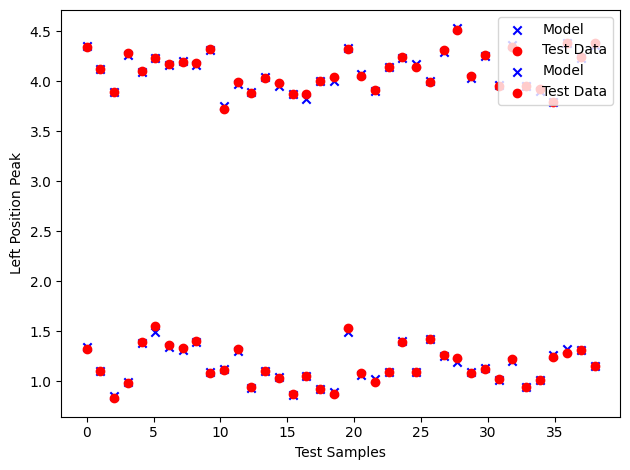

In [112]:
#Boilerplate for printing of one feature results

#inverse transform of prediction and test data to get back real values from scaled data

pred_inv = scaler.inverse_transform(predictions)
data_inv = scaler.inverse_transform(y_test)

w1=np.linspace(0,38,38) #38 is sample size of test after test/train split 

plt.scatter(w1,pred_inv[:,2:3]/10,label="Model", marker='x', color="blue")
plt.scatter(w1,data_inv[:,2:3]/10,label="Test Data",color="red")
plt.scatter(w1,pred_inv[:,3:4]/10,label="Model", marker='x', color="blue")
plt.scatter(w1,data_inv[:,3:4]/10,label="Test Data",color="red")
plt.annotate("Model NMRSE = {:.4f}".format(nmrs(predictions[:,2:3],y_test)), (25, 0.5))
plt.annotate("Model MSE =  {:.4f}".format(mse(predictions[:,2:3],y_test)), (25, 0.6))
plt.xlabel("Test Samples")
plt.ylabel("Left Position Peak")
plt.legend(loc="upper right")
  #  axs[2].set_ylim(0.5, 1)
  # axs[2].set_title("1 Layer - 100 Neurons N.N")
plt.tight_layout()
#plt.savefig('3Model_Pred', bbox_inches='tight')
plt.show()

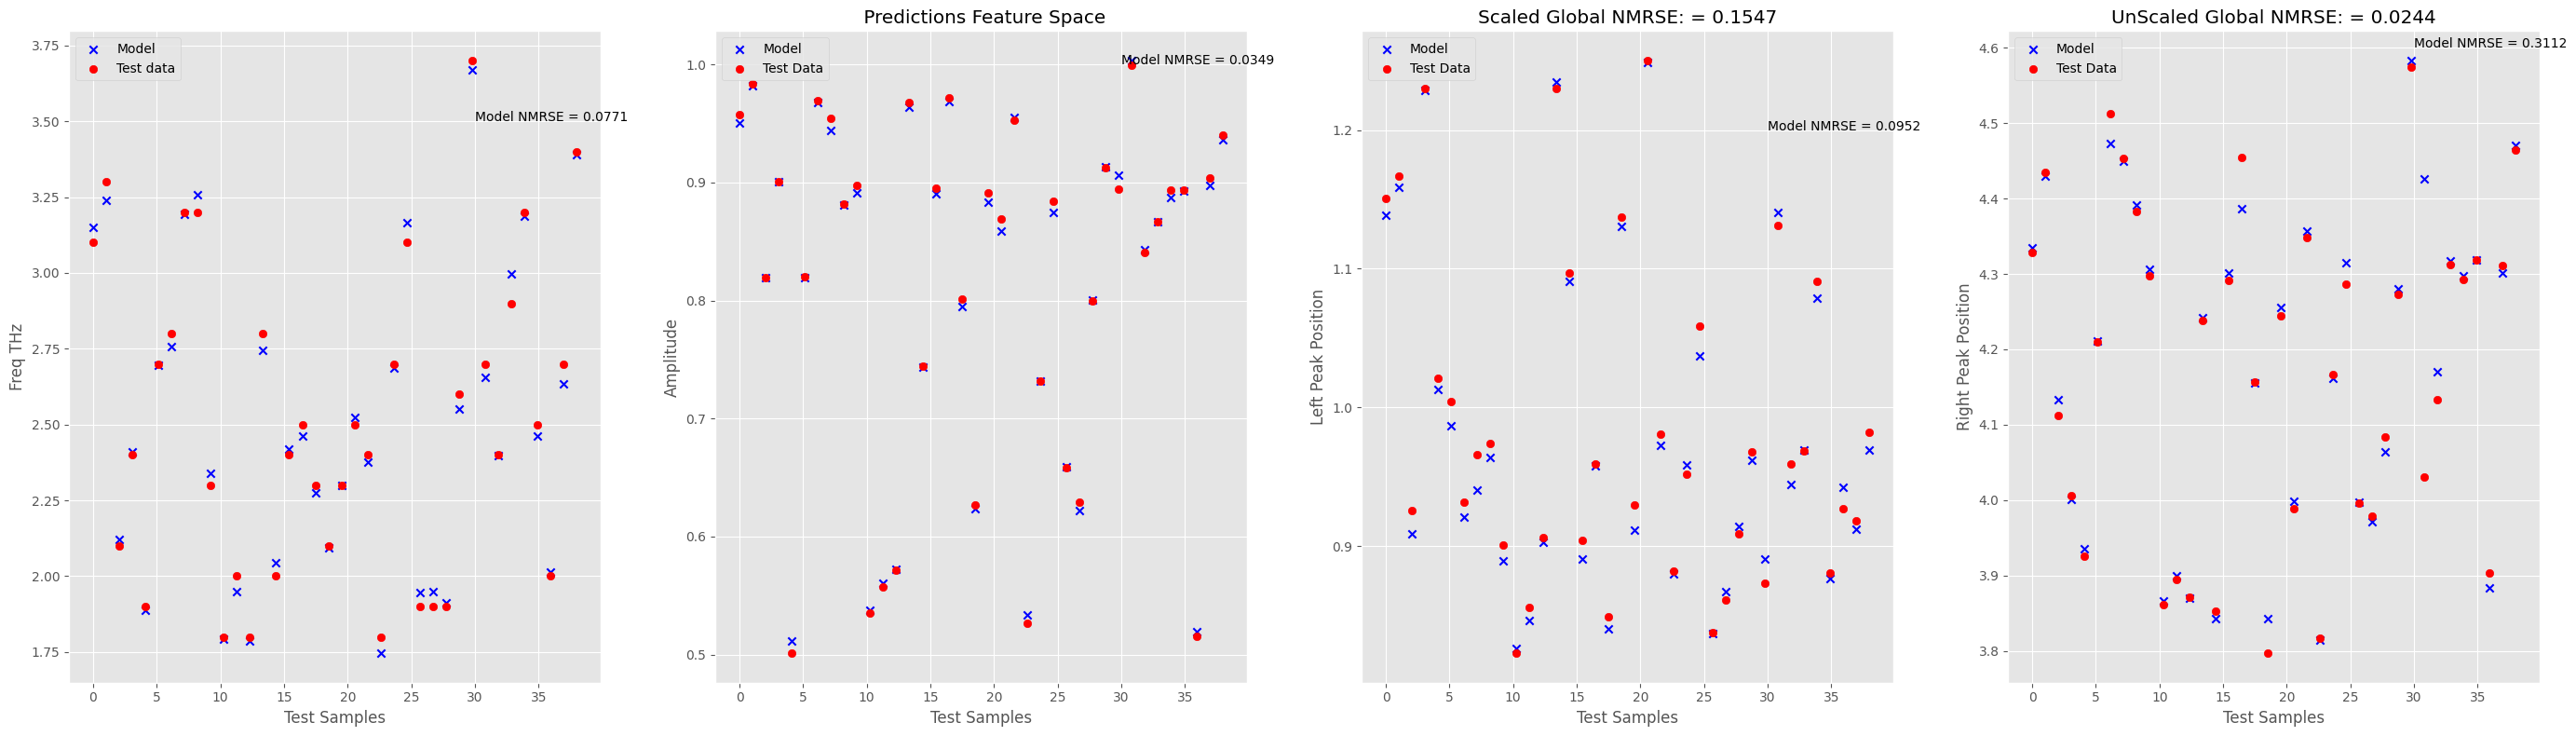

In [165]:
#Boilerplate for printing of three feature results
pred = predictions
ydata= y_test
#inverse transform of prediction and test data to get back real values from scaled data
pred_inv = scaler.inverse_transform(pred)
data_inv = scaler.inverse_transform(ydata)

w1=np.linspace(0,38,38)

with plt.style.context('ggplot'):#sanity check if correct waveforms are loaded
    fig, axs = plt.subplots(1, 4, figsize=(28, 8))
#plot for 3 features output
    axs[0].scatter(w1,pred_inv[:,0:1]/1000,label="Model",marker='x', color="blue")
    axs[0].scatter(w1,data_inv[:,0:1]/1000,label="Test data",color="red") 
    axs[0].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,0:1],data_inv[:,0:1])),(30, 3.5)) #define coordinate for nmrse results plotting))
    axs[0].set_xlabel("Test Samples")
    axs[0].set_ylabel("Freq THz")
    axs[0].legend(loc="upper left")


    axs[1].scatter(w1,pred_inv[:,1:2],label="Model", color="blue", marker='x')
    axs[1].scatter(w1,data_inv[:,1:2],label="Test Data",color="red")
    axs[1].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,1:2],data_inv[:,1:2])), (30, 1)) #define coordinate for nmrse results plotting))
    axs[1].set_xlabel("Test Samples")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend(loc="upper left")
    axs[1].set_title(" Predictions Feature Space")

    axs[2].scatter(w1,pred_inv[:,2:3]/1000,label="Model", marker='x', color="blue")
    axs[2].scatter(w1,data_inv[:,2:3]/1000,label="Test Data",color="red")
    axs[2].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,2:3],data_inv[:,2:3])), (30, 1.2)) #define coordinate for nmrse results plotting))
    axs[2].set_xlabel("Test Samples")
    axs[2].set_ylabel("Left Peak Position")
    axs[2].legend(loc="upper left")
    axs[2].set_title("Scaled Global NMRSE: = {:.4f}".format((nmrs(pred,ydata))))

    axs[3].scatter(w1,pred_inv[:,3:4]/1000,label="Model", marker='x', color="blue")
    axs[3].scatter(w1,data_inv[:,3:4]/1000,label="Test Data",color="red")
    axs[3].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,3:4],data_inv[:,3:4])), (30, 4.6)) #define coordinate for nmrse results plotting))
    axs[3].set_xlabel("Test Samples")
    axs[3].set_ylabel("Right Peak Position")
    axs[3].legend(loc="upper left")
    axs[3].set_title("UnScaled Global NMRSE: = {:.4f}".format((nmrs(pred_inv,data_inv))))

plt.tight_layout()
#plt.savefig('1000_Data_GeLU_2L_28N', bbox_inches='tight')
plt.show()



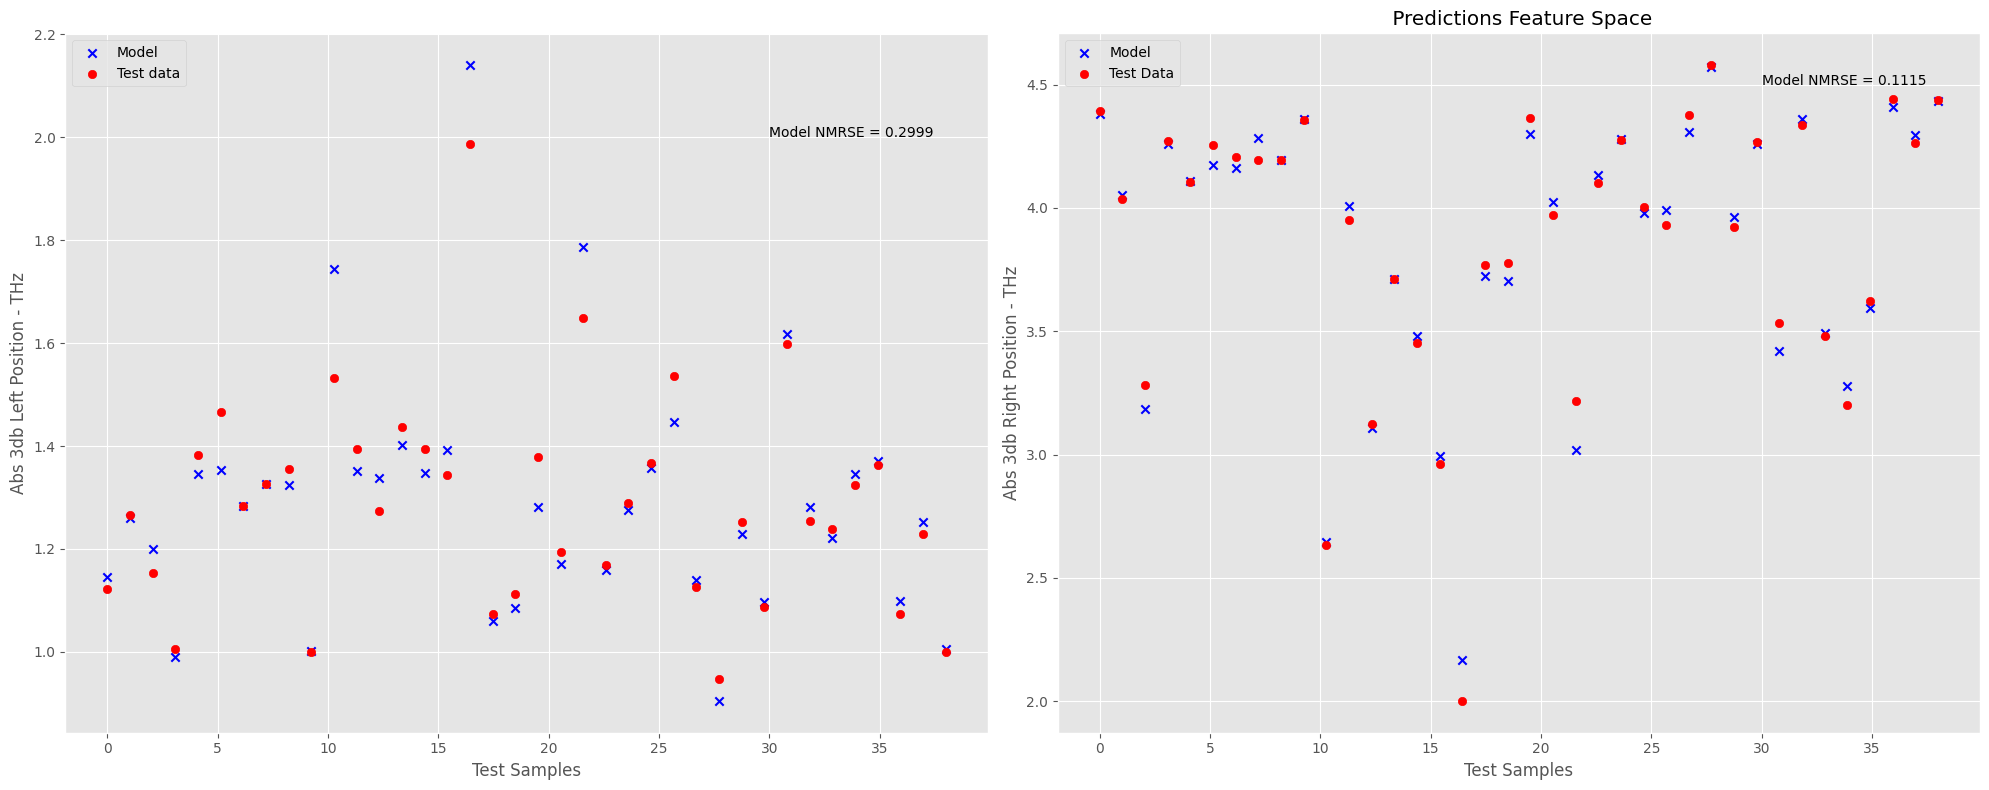

In [58]:
#Boilerplate for printing of one feature results

#inverse transform of prediction and test data to get back real values from scaled data
pred_inv = scaler.inverse_transform(pred)
data_inv = scaler.inverse_transform(ydata)


w1=np.linspace(0,38,38)

with plt.style.context('ggplot'):#sanity check if correct waveforms are loaded
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
#plot for 3 features output
    axs[0].scatter(w1,pred_inv[:,4:5]/1000,label="Model",marker='x', color="blue")
    axs[0].scatter(w1,data_inv[:,4:5]/1000,label="Test data",color="red") 
    axs[0].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,4:5],data_inv[:,4:5])),(30, 2.0)) #define coordinate for nmrse results plotting))
    axs[0].set_xlabel("Test Samples")
    axs[0].set_ylabel("Abs 3db Left Position - THz")
    axs[0].legend(loc="upper left")


    axs[1].scatter(w1,pred_inv[:,5:6]/1000,label="Model", color="blue", marker='x')
    axs[1].scatter(w1,data_inv[:,5:6]/1000,label="Test Data",color="red")
    axs[1].annotate("Model NMRSE = {:.4f}".format(nmrs(pred_inv[:,5:6],data_inv[:,5:6])), (30, 4.5)) #define coordinate for nmrse results plotting))
    axs[1].set_xlabel("Test Samples")
    axs[1].set_ylabel("Abs 3db Right Position - THz")
    axs[1].legend(loc="upper left")
    axs[1].set_title(" Predictions Feature Space")

plt.tight_layout()
#plt.savefig('1000_Data_GeLU_2L_28N', bbox_inches='tight')
plt.show()
